# Movielens 영화 SBR
---

`Movielens 1M Dataset`을 기반으로, Session based Recommendation 시스템을 제작해 보자 (ノ^∇^)ノ

## STEP 0. 설계
---

1. 데이터 수집 : `Movielens 1M Dataset`을 다운로드 받는다. 
2. 데이터의 전처리
    - 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행한다.
    - 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의한다.
3. 미니 배치의 구성
    - Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성한다.
    - 단,  Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있다.
4. 모델 구성
5. 모델 학습
    - 다양한 하이퍼파라미터를 변경해 보며 검증을 진행해 본다.
    - 이때, Recall, MRR 등의 개념들도 함께 관리될 수 있도록 한다.
6. 모델 테스트
    - 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 본다.

## STEP 1. 데이터 수집 및 전처리
---

### 1. 데이터 다운로드

In [ ]:
# !wget http://files.grouplens.org/datasets/movielens/ml-1m.zip -P ./data
# !unzip ./data/ml-1m.zip -d ./data/ml-1m

In [4]:
! ls ./data/ml-1m/

README	movies.dat  ratings.dat  users.dat


### 2. 데이터 불러오기

#### 1. import package

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
# initialization gpu ########################################################
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [7]:
!pwd

/home/aiffel-dj1/workspace/aiffel-exploration-workspace/E17_session_based_recommendation


In [3]:
workspace_path = Path(os.getenv('HOME') + '/workspace/aiffel-exploration-workspace/E17_session_based_recommendation')
data_path = workspace_path / 'data/ml-1m'
train_path = data_path / 'ratings.dat'

#### 2. 데이터 불러오기

In [6]:
def load_data(data_path: Path):
    data = pd.read_csv(data_path, sep='::', header=None,
                      names=['UserId', 'ItemId', 'Rating', 'Time'],
                      dtype={0: np.int32, 1: np.int32, 2: np.int32})
    data['Time'] = pd.to_datetime(data['Time'], unit='s')
    data.sort_values(['UserId', 'Time'], inplace=True)
    return data

In [7]:
data = load_data(train_path)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [8]:
data_item = pd.read_csv(data_path / 'movies.dat', sep='::', header=None,
                       names=['ItemId', 'Title', 'Genres'],
                       dtype={0: np.int32, 1: str, 2: str })
data_item

,ItemId,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [9]:
data = pd.merge(data, data_item, how='left', on='ItemId')
data

,UserId,ItemId,Rating,Time,Title,Genres
0,1,3186,4,2000-12-31 22:00:19,"Girl, Interrupted (1999)",Drama
1,1,1270,5,2000-12-31 22:00:55,Back to the Future (1985),Comedy|Sci-Fi
2,1,1721,4,2000-12-31 22:00:55,Titanic (1997),Drama|Romance
3,1,1022,5,2000-12-31 22:00:55,Cinderella (1950),Animation|Children's|Musical
4,1,2340,3,2000-12-31 22:01:43,Meet Joe Black (1998),Romance
...,...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,Body Heat (1981),Crime|Thriller
1000205,6040,1921,4,2001-08-10 14:41:04,Pi (1998),Sci-Fi|Thriller
1000206,6040,1784,3,2001-08-10 14:41:04,As Good As It Gets (1997),Comedy|Drama
1000207,6040,161,3,2001-08-10 14:41:26,Crimson Tide (1995),Drama|Thriller|War


데이터 분석을 위하여 ratings 테이블에 영화 정보를 추가하였다.

In [110]:
data.sort_values(['UserId', 'Time'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   UserId  1000209 non-null  int32         
 1   ItemId  1000209 non-null  int32         
 2   Rating  1000209 non-null  int32         
 3   Time    1000209 non-null  datetime64[ns]
 4   Title   1000209 non-null  object        
 5   Genres  1000209 non-null  object        
dtypes: datetime64[ns](1), int32(3), object(2)
memory usage: 42.0+ MB


In [111]:
pd.options.display.float_format = '{:,.4f}'.format
data.describe()

,UserId,ItemId,Rating
count,"1,000,209.0000","1,000,209.0000","1,000,209.0000"
mean,"3,024.5123","1,865.5399",3.5816
std,"1,728.4127","1,096.0407",1.1171
min,1.0000,1.0000,1.0000
25%,"1,506.0000","1,030.0000",3.0000
50%,"3,070.0000","1,835.0000",4.0000
75%,"4,476.0000","2,770.0000",4.0000
max,"6,040.0000","3,952.0000",5.0000


###  3. 데이터 확인

- 유저수(UserId)와 아이템의 수(ItemId) 확인

In [112]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

- Session length -> User length

In [113]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [114]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [115]:
user_length.min(), user_length.max()

(20, 2314)

총 6040명의 유저가 존재하며, 한 명의 유저는 평균적으로 약 165편의 영화를 감상하였다. 가장 적게 영화를 본 유저와 가장 많은 영화를 본 유저의 감상횟수는 각각 20, 2314이다.

In [116]:
user_length.quantile(0.99), user_length.quantile(0.999)

(906.659999999998, 1343.181000000005)

유저의 99%의 감상횟수는 906회 이하이고, 99.9%의 감상횟수는 1343회 이하이다.

- user_length 누적합 시각화

In [117]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20     0.0142
21     0.0293
22     0.0421
23     0.0555
24     0.0689
        ...  
1271   0.9982
1277   0.9983
1286   0.9985
1302   0.9987
1323   0.9988
Length: 736, dtype: float64

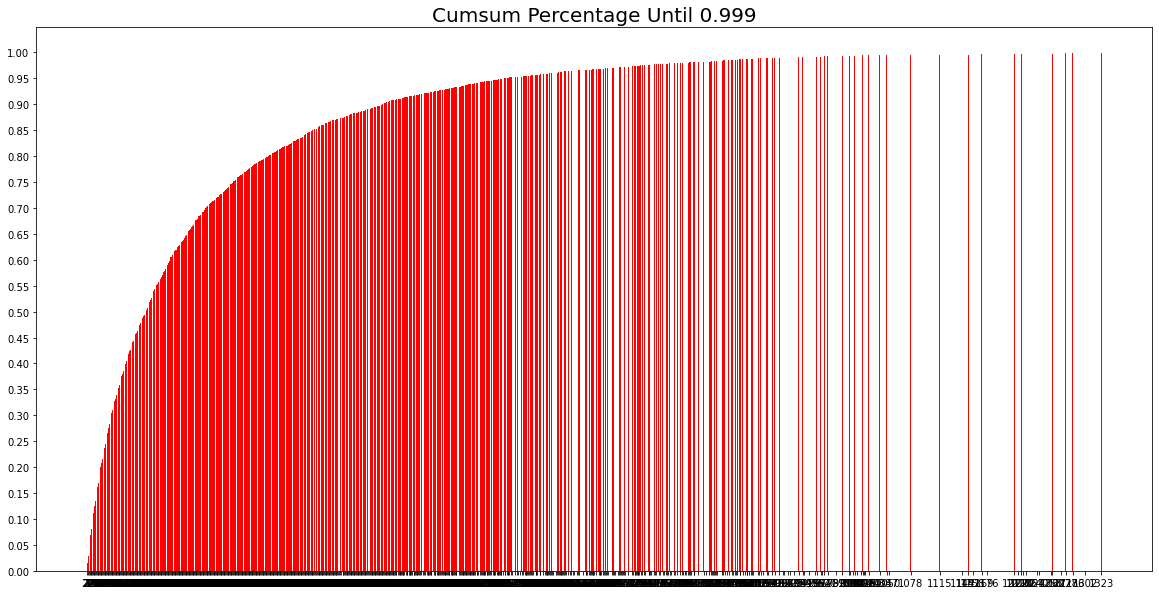

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

데이터에서 불필요하거나 비정상적인 데이터를 걸러내기 위하여 누적합 그래프를 그려보았다. 그래프의 후반데 그래프간 간격이 벌어지기는 하지만 너무 동떨어져 있는 데이터는 존해하지 않으므로 삭제는 따로 하지 않기로 하였다. 만약, 차후에 데이터를 정제할 필요가 있다면 length가 1078 이상인 데이터에 대하여 삭제를 검토해 볼 만하다.

- Session time

In [119]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

데이터의 수집기간은 약 삼년이다. 이미 영화관 상영이 종료된 영화들의 vod 감상의 경우, 트렌트에 큰 영향을 받지 않을 수도 있고 데이터의 양이 풍부한 편도 아니기 때문에 데이터의 정제 기준에 시간을 포함시키지 않기로 하였다.

- ratings

In [120]:
data['Rating'].min(), data['Rating'].max()

(1, 5)

세션 데이터가 존재하는 것은 유저가 해당 아이템에 관심이 있는 것이라고 판단된다. 하지만 평점이 낮은(1~2) 영화의 경우 유적 선호한다고 판단하기 어려우므로 해당되는 데이터를 삭제하는 것이 바람직하다.

In [121]:
data.drop(data[data['Rating'] <= 2].index, inplace=True)

In [122]:
data['Rating'].min(), data['Rating'].max()

(3, 5)

In [123]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6039, 3628)

유니크한 아이템의 후가 3706에서 3628로 줄어들었다.

- ItemId length

In [58]:
item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2000
2        551
3        339
4        102
5        214
        ... 
3948     752
3949     280
3950      47
3951      36
3952     353
Length: 3628, dtype: int64

In [60]:
item_length.min(), item_length.max(), item_length.mean(), item_length.median()

(1, 3211, 230.56174200661522, 87.0)

영화들 중 단 한번 재생된 영화가 존재하며, 영화의 평균 재생 횟수는 약 230번이다.

In [61]:
item_length.quantile(0.99), item_length.quantile(0.999), 

(1721.46, 2618.815000000078)

In [63]:
item_length_max = item_length[item_length >= 2618]
item_length_max

ItemId
260     2910
1196    2885
1210    2716
2858    3211
dtype: int64

### 4. Data Cleansing

In [137]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_view) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_view)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

# 길이가 1인 세션 제거
def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

# 너무 적게 클릭된 아이템 제거
def cleanse_unpopular_item(data: pd.DataFrame, least_view):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_view].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [138]:
print(f"before data cleansing - user length : {data['UserId'].nunique()}")
print(f"before data cleansing - item length : {data['ItemId'].nunique()}")
data = cleanse_recursive(data, shortest=2, least_view=5)
print(f"after data cleansing - user length : {data['UserId'].nunique()}")
print(f"after data cleansing - item length : {data['ItemId'].nunique()}")

before data cleansing - user length : 6039
before data cleansing - item length : 3628
after data cleansing - user length : 6038
after data cleansing - item length : 3307


### 5. Train / Valid / Test split

데이터를 시간 순으로 나열 후 가장 마지막 4달(120일) 기간 동안을 Test로, 또 그 이전의 4달까지를 Validation set으로 나눈다.

- split

In [141]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    return train, test

In [142]:
train, test = split_by_date(data,  n_days=120)
train, val  = split_by_date(train, n_days=120)
print(train.shape, test.shape, val.shape)

(825522, 6) (5343, 6) (4924, 6)


In [143]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t User: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [167]:
stats_info(train, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 825522
	 User: 6037
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-03 16:04:32

* valid Set Stats Info
	 Events: 4924
	 User: 269
	 Items: 1812
	 First Time : 2002-07-03 17:31:04
	 Last Time : 2002-10-31 16:33:08

* test Set Stats Info
	 Events: 5343
	 User: 271
	 Items: 1801
	 First Time : 2002-10-31 19:58:49
	 Last Time : 2003-02-28 17:49:50



- item indexing : train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱을 진행한다.

In [161]:
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df.reset_index(drop=True)

train = indexing(train, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [168]:
val[val['item_idx'] == -1]

,UserId,ItemId,Rating,Time,Title,Genres,item_idx


In [169]:
test[test['item_idx'] == -1]

,UserId,ItemId,Rating,Time,Title,Genres,item_idx


- 정제된 데이터를 저장한 후, 이후로는 저장된 데이터를 불러와 사용하도록 한다.

In [4]:
save_path = data_path / 'processed'

In [170]:
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [6]:
# data load
train = pd.read_pickle(save_path / 'train.pkl')
val = pd.read_pickle(save_path / 'valid.pkl')
test = pd.read_pickle(save_path / 'test.pkl')

In [7]:
train.head()

,UserId,ItemId,Rating,Time,Title,Genres,item_idx
0,1,3186,4,2000-12-31 22:00:19,"Girl, Interrupted (1999)",Drama,0
1,1,1270,5,2000-12-31 22:00:55,Back to the Future (1985),Comedy|Sci-Fi,1
2,1,1721,4,2000-12-31 22:00:55,Titanic (1997),Drama|Romance,2
3,1,1022,5,2000-12-31 22:00:55,Cinderella (1950),Animation|Children's|Musical,3
4,1,2340,3,2000-12-31 22:01:43,Meet Joe Black (1998),Romance,4


In [8]:
val.head()

,UserId,ItemId,Rating,Time,Title,Genres,item_idx
0,65,2194,5,2002-09-29 21:33:17,"Untouchables, The (1987)",Action|Crime|Drama,105
1,157,3753,4,2002-10-11 16:42:02,"Patriot, The (2000)",Action|Drama|War,365
2,157,912,5,2002-10-11 16:53:02,Casablanca (1942),Drama|Romance|War,326
3,157,3196,5,2002-10-11 16:53:02,Stalag 17 (1953),Drama|War,1490
4,157,1944,4,2002-10-11 16:53:02,From Here to Eternity (1953),Drama|Romance|War,1631


In [9]:
test.head()

,UserId,ItemId,Rating,Time,Title,Genres,item_idx
0,36,2269,5,2002-12-22 08:05:50,Indecent Proposal (1993),Drama,1252
1,36,1701,4,2002-12-22 08:05:50,Deconstructing Harry (1997),Comedy|Drama,440
2,36,2694,3,2002-12-22 08:08:14,Big Daddy (1999),Comedy,793
3,36,3786,4,2002-12-22 08:08:41,But I'm a Cheerleader (1999),Comedy,206
4,36,2369,4,2002-12-22 08:09:24,Desperately Seeking Susan (1985),Comedy|Romance,851


## STEP 3. 미니 배치의 구성
---

### 1. SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스

- 정의

In [10]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

- 인스턴스 확인

In [35]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,Title,Genres,item_idx
0,1,3186,4,2000-12-31 22:00:19,"Girl, Interrupted (1999)",Drama,0
1,1,1270,5,2000-12-31 22:00:55,Back to the Future (1985),Comedy|Sci-Fi,1
2,1,1721,4,2000-12-31 22:00:55,Titanic (1997),Drama|Romance,2
3,1,1022,5,2000-12-31 22:00:55,Cinderella (1950),Animation|Children's|Musical,3
4,1,2340,3,2000-12-31 22:01:43,Meet Joe Black (1998),Romance,4
5,1,1836,5,2000-12-31 22:02:52,"Last Days of Disco, The (1998)",Drama,5
6,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,6
7,1,2804,5,2000-12-31 22:11:59,"Christmas Story, A (1983)",Comedy|Drama,7
8,1,1207,4,2000-12-31 22:11:59,To Kill a Mockingbird (1962),Drama,8
9,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,9


In [36]:
train_dataset.click_offsets

array([     0,     53,    169, ..., 825127, 825246, 825522], dtype=int32)

In [37]:
train_dataset.session_idx

array([   0,    1,    2, ..., 6034, 6035, 6036])

### 2. SessionDataLoader
`SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스

In [11]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [38]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,Title,Genres,item_idx
0,1,3186,4,2000-12-31 22:00:19,"Girl, Interrupted (1999)",Drama,0
1,1,1270,5,2000-12-31 22:00:55,Back to the Future (1985),Comedy|Sci-Fi,1
2,1,1721,4,2000-12-31 22:00:55,Titanic (1997),Drama|Romance,2
3,1,1022,5,2000-12-31 22:00:55,Cinderella (1950),Animation|Children's|Musical,3
4,1,2340,3,2000-12-31 22:01:43,Meet Joe Black (1998),Romance,4
5,1,1836,5,2000-12-31 22:02:52,"Last Days of Disco, The (1998)",Drama,5
6,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,6
7,1,2804,5,2000-12-31 22:11:59,"Christmas Story, A (1983)",Comedy|Drama,7
8,1,1207,4,2000-12-31 22:11:59,To Kill a Mockingbird (1962),Drama,8
9,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,9


In [39]:
iter_ex = iter(train_data_loader)

In [23]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## STEP 4. 모델 구성
---

### 1. 성능지표

- recall@k
    - K개를 추천 받았을 때, 추천되었어야 했을 관련된 항목이 몇개나 추천되었는가에 대한 지표. 
    - [relevant한 아이템의 개수] / [K개의 추천 중 relevant한 아이템의 개수]

In [12]:
def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

- MRR(Mean Reciprocal Rank)
    - Reciprocal Rank : 첫 번째로 등장하는 relevant한 아이템이 추천상 몇 번째에 위치하는가
    - MRR은 모든 유저에 대한 Reciprocal Rank의 역수의 평균

In [13]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

### 2. 모델 구성

- create_model : 모델을 생성하여 반환해주는 함수

In [14]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions], name='SBR')
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

- Args : 하이퍼 파리미터 및 dataset 관리 클래스

In [15]:
class Args:
    def __init__(self, train, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.val = val
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_sessions = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

## STEP 5. 모델 학습
---

In [16]:
def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)

In [372]:
def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []
    accuracy_list = []
    
    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        
        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.
        
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])  
        
        pred_first = np.array([ pred[0] for pred in pred_arg ])
        accuracy_list.append((pred_first == label).sum() / len(label))
        
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    accuracy = np.mean(accuracy_list)
    return recall, mrr, accuracy

In [368]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
    matrix = []

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])
            
        val_recall, val_mrr, val_acc = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        
        matrix.append({'train_loss' : result[0],
                       'train_accuracy' : result[1],
                       'val_recall' : val_recall,
                       'val_mrr': val_mrr,
                       'val_acc' : val_acc})
    return matrix

In [369]:
args = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [370]:
model = create_model(args)

Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_45 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_45 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [373]:
history = train_model(model, args)

Train:   0%|          | 0/6402 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.6] 

	 - Recall@20 epoch 1: 0.078125
	 - MRR@20    epoch 1: 0.017609



Train:   0%|          | 0/6402 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.56] 

	 - Recall@20 epoch 2: 0.090625
	 - MRR@20    epoch 2: 0.022241



Train:   0%|          | 0/6402 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.46] 

	 - Recall@20 epoch 3: 0.098437
	 - MRR@20    epoch 3: 0.023736



Train:   0%|          | 0/6402 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.23]  

	 - Recall@20 epoch 4: 0.103125
	 - MRR@20    epoch 4: 0.026392



Evaluation:  28%|██▊       | 10/36 [00:04<00:11,  2.36it/s]

	 - Recall@20 epoch 5: 0.107031
	 - MRR@20    epoch 5: 0.027270



In [89]:
def show_history(history, title=None):
    fig, axes = plt.subplots(2, 2, figsize=(9,6))
    axes = [ y for x in axes for y in x ]
    x = range(1, len(history) + 1)
    
    def set_labels(ax, xlabel, ylabel, title):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.legend()
    
    axes[0].plot(x, [h['train_loss'] for h in history], label='Training loss')
    set_labels(axes[0], 'Epochs', 'Loss', 'Loss')
    
    axes[1].plot(x, [h['train_accuracy'] for h in history], label='Training accuracy')
    axes[1].plot(x, [h['val_acc'] for h in history], label='Validation accuracy')
    set_labels(axes[1], 'Epochs', 'Accuracy', 'Accuracy')
    
    axes[2].plot(x, [h['val_recall'] for h in history], label='Validation Recall')
    set_labels(axes[2], 'Epochs', 'Recall', 'Validation Recall')
    
    axes[3].plot(x, [h['val_mrr'] for h in history], label='Validation MRR')
    set_labels(axes[3], 'Epochs', 'MRR', 'Validation MRR')
    
    if title : plt.suptitle(title)
    plt.tight_layout()
    plt.show()

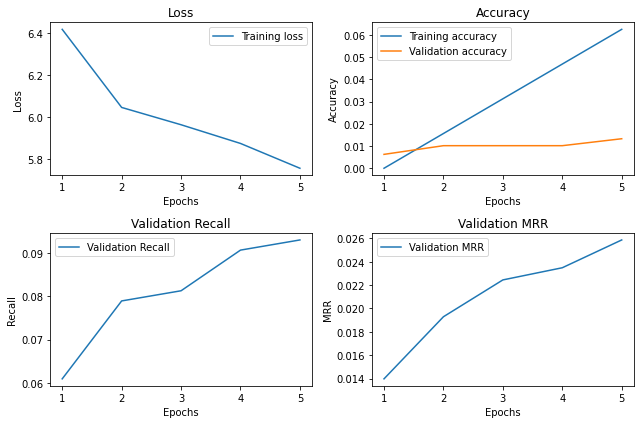

In [78]:
show_history(history)

학습 결과를 확인해보니
- Loss는 감소하고
- Train Accuracy는 증가하고
- Recall이 증가하고
- MRR이 증가하는 추세를 보였다.

따라서 모델이 정상적으로 학습되고 있다고 볼 수 있었다.

## STEP 6. 모델 테스트
---

In [79]:
def test_model(model, args, test):
    test_recall, test_mrr, test_acc = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [83]:
res = test_model(model, args, test)

Evaluation:  23%|██▎       | 9/39 [00:03<00:12,  2.36it/s]

	 - Recall@20: 0.144097
	 - MRR@20: 0.046021



- 모델의 추론 결과로부터 평가지표들을 계산하여 보았을 때, Recall@20의 값이 0.144097를 얻을 수 있었다. 20개의 영화를 추천받았을 때, 그 중 2.8개는 유저가 선호하는 영화가 포함되었다는 뜻이다.
- MRR@20은 0.04로 아주 낮은 수치를 기록하였는데, 이는 추천 받은 영화 중 제일 먼저 등장하는 영화가 유저가 선호하는 영화인가에 대한 정보이다. 0.04를 기록하였는데 이는 20개의 영화를 추천 받았을 때, 첫 번째로 추천해 주는 영화가 8%의 확률로 유저가 선호하는 영화라는 것을 뜻한다.
- 수치로 보았을 때, 모델의 성능이 그렇게 좋다고 볼 수 없다. 모델을 개선해 보자🤔

## STEP 7. 모델 개선
---

- grid search

In [280]:
def get_metrics_remove_tqdm(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []
    accuracy_list = []
    
    for inputs, label, mask in loader:
        reset_hidden_states(model, mask)
        
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        
        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.
        
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])  
        
        pred_first = np.array([ pred[0] for pred in pred_arg ])
        accuracy_list.append((pred_first == label).sum() / len(label))
        
    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    accuracy = np.mean(accuracy_list)
    return recall, mrr, accuracy

In [109]:
def train_model_remove_tqdm(model, args):
    train_dataset = SessionDataset(args.train)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
    matrix = []

    for epoch in range(1, args.epochs + 1):        
        for feat, target, mask in train_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)
            result = model.train_on_batch(input_ohe, target_ohe)
            
        val_recall, val_mrr, val_acc = get_metrics_remove_tqdm(args.val, model, args, args.k)  # valid set에 대해 검증합니다
        matrix.append({'train_loss' : result[0],
                       'train_accuracy' : result[1],
                       'val_recall' : val_recall,
                       'val_mrr': val_mrr,
                       'val_acc' : val_acc})
    return matrix

In [148]:
def grid_search(args):
    res = []
    
    for arg in args:
        print(f'🕊 hsz({arg.hsz}), drop_rate({arg.drop_rate}), learning_rate({arg.lr}), epochs({arg.epochs})')
        model = create_model(arg)
        history = train_model_remove_tqdm(model, arg)
        show_history(history)
        
        test_recall, test_mrr, test_acc = get_metrics(arg.test, model, arg, 20)
        
        print(f"- Recall@{arg.k}: {test_recall:3f}")
        print(f"- MRR@{arg.k}: {test_mrr:3f}\n")
        print()
        
        res.append({
            'hidden size' : arg.hsz,
            'drop rate' : arg.drop_rate,
            'learning rate' : arg.lr,
            'epochs' : arg.epochs,
            f'Recall@{arg.k}' : test_recall,
            f'MRR@{arg.k}' : test_mrr
        })
    return res

- display grid search result graph

In [199]:
def show_grid_search_result(res, index, columns):
    df = pd.DataFrame(res)
    display(df)
    
    fig, axes = plt.subplots(1, len(columns), figsize=(4*len(columns), 4))
    for ax, col in zip(axes, columns):
        df.plot(kind='bar', x=index, y=col, ax=ax)
        ax.set_ylim(df[col].min() - df[col].mad())
        ax.set_title(col)
        ax.get_legend().remove()
        
    plt.tight_layout()
    plt.show()

### 1. 하이퍼 파리미터 튜닝 - hidden size

In [152]:
args_hsz = [Args(train, val, test, batch_size=128, hsz=10, drop_rate=0.1, lr=0.001, epochs=10, k=20),
            Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20),
            Args(train, val, test, batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)]

🕊 hsz(10), drop_rate(0.1), learning_rate(0.001), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 10), (128, 10)]    99570     
_________________________________________________________________
dropout_22 (Dropout)         (128, 10)                 0         
_________________________________________________________________
dense_22 (Dense)             (128, 3307)               36377     
Total params: 135,947
Trainable params: 135,947
Non-trainable params: 0
_________________________________________________________________


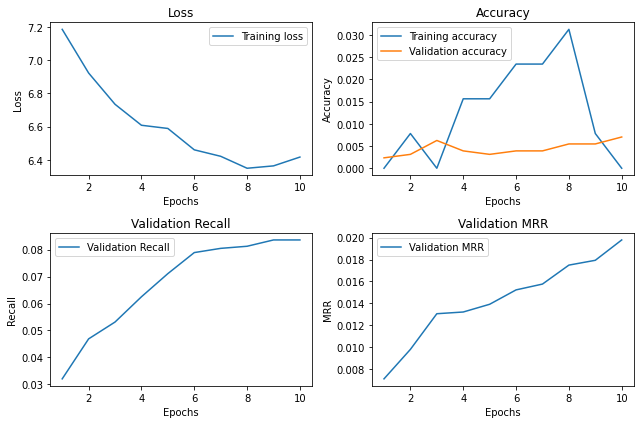

Evaluation:  23%|██▎       | 9/39 [00:03<00:13,  2.29it/s]


- Recall@20: 0.121528
- MRR@20: 0.036972


🕊 hsz(50), drop_rate(0.1), learning_rate(0.001), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_23 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_23 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


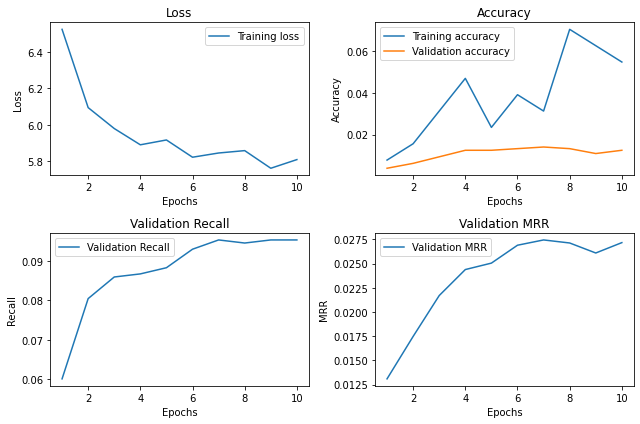

Evaluation:  23%|██▎       | 9/39 [00:03<00:11,  2.53it/s]


- Recall@20: 0.138021
- MRR@20: 0.043916


🕊 hsz(100), drop_rate(0.1), learning_rate(0.001), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1022700   
_________________________________________________________________
dropout_24 (Dropout)         (128, 100)                0         
_________________________________________________________________
dense_24 (Dense)             (128, 3307)               334007    
Total params: 1,356,707
Trainable params: 1,356,707
Non-trainable params: 0
_________________________________________________________________


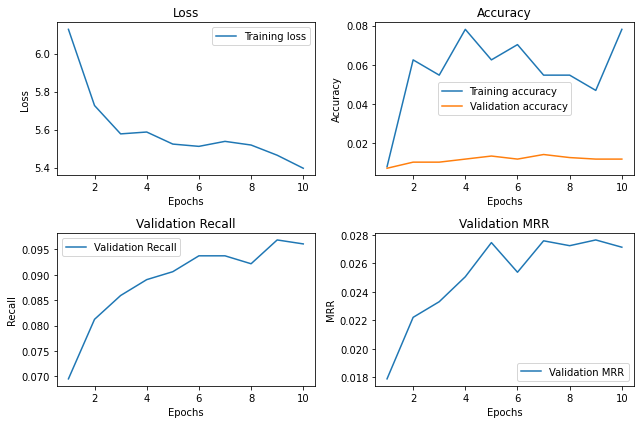

Evaluation:  23%|██▎       | 9/39 [00:03<00:12,  2.36it/s]

- Recall@20: 0.138889
- MRR@20: 0.045565




In [153]:
res = grid_search(args_hsz)

,hidden size,drop rate,learning rate,epochs,Recall@20,MRR@20
0,10,0.1,0.001,10,0.121528,0.036972
1,50,0.1,0.001,10,0.138021,0.043916
2,100,0.1,0.001,10,0.138889,0.045565


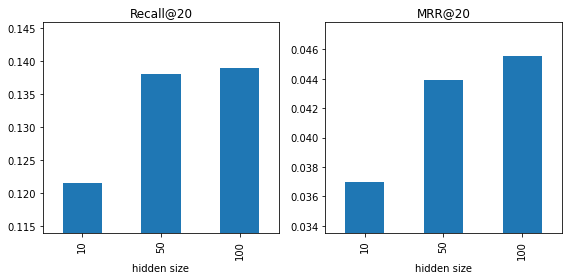

In [200]:
show_grid_search_result(res, 'hidden size', ['Recall@20', 'MRR@20'])

- hidden size를 증가시켰더니, Recall@20, MRR@20이 각각 증가하였다.
- 하지만, hidden size가 50에서 100으로 증가할 때, Recall@20와 MRR@20 극적인 증가세를 보이지 않지만 학습시간은 유의미하게 길어지므로 이후 실험에서는 50을 사용하기로 하였다.
- epochs를 기존의 실험 보다 두배 증가시킨 10을 사용하였는데 이전의 실험보다 Recall@20와 MRR@20가 감소(0.144097 -> 0.138021, 0.046021 -> 0.043916) 하였다.


### 2.하이퍼 파라미터 튜닝 - learning rate

In [201]:
args_lr = [Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20),
           Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20),
           Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.1, epochs=10, k=20)]

🕊 hsz(50), drop_rate(0.1), learning_rate(0.001), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_25 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_25 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


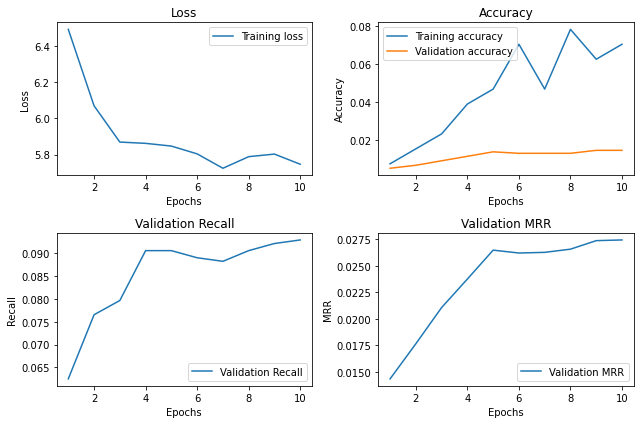

Evaluation:  23%|██▎       | 9/39 [00:03<00:12,  2.49it/s]


- Recall@20: 0.147569
- MRR@20: 0.048856


🕊 hsz(50), drop_rate(0.1), learning_rate(0.01), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_26 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_26 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


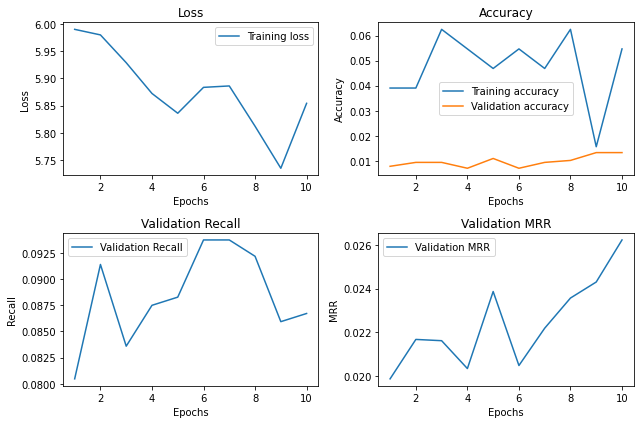

Evaluation:  23%|██▎       | 9/39 [00:03<00:11,  2.56it/s]


- Recall@20: 0.125000
- MRR@20: 0.034618


🕊 hsz(50), drop_rate(0.1), learning_rate(0.1), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_27 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_27 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


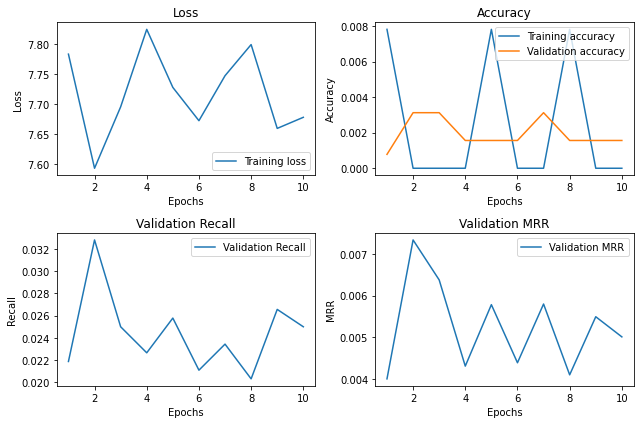

Evaluation:  23%|██▎       | 9/39 [00:03<00:12,  2.37it/s]

- Recall@20: 0.029514
- MRR@20: 0.006453




In [202]:
res_lr = grid_search(args_lr)

,hidden size,drop rate,learning rate,epochs,Recall@20,MRR@20
0,50,0.1,0.001,10,0.147569,0.048856
1,50,0.1,0.010,10,0.125000,0.034618
2,50,0.1,0.100,10,0.029514,0.006453


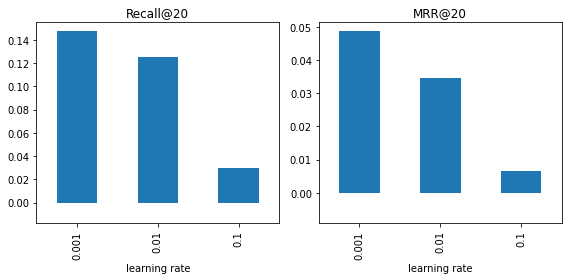

In [204]:
show_grid_search_result(res_lr, 'learning rate', ['Recall@20', 'MRR@20'])

- learning rate를 증가시켰더니, Recall@20, MRR@20이 각각 감소하였다.
- 가장 좋은 성능을 보인 0.001을 이후 실험에서 사용하기로 하자.

### 3. 하이퍼 파라미터 튜닝 - drop rate

In [207]:
args_drop = [Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20),
             Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.001, epochs=10, k=20),
             Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.001, lr=0.001, epochs=10, k=20)]

🕊 hsz(50), drop_rate(0.1), learning_rate(0.001), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_31 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_31 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


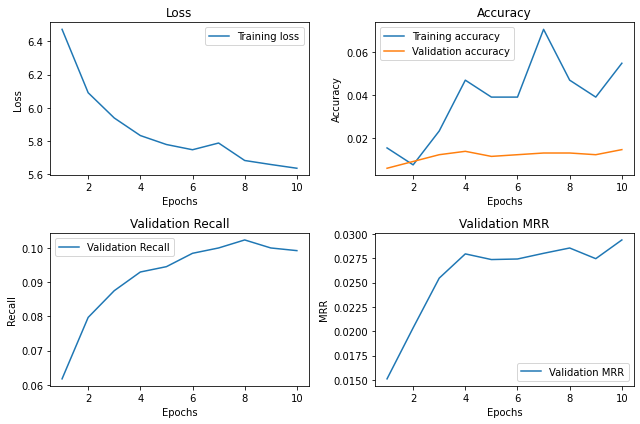

Evaluation:  23%|██▎       | 9/39 [00:03<00:12,  2.49it/s]


- Recall@20: 0.148438
- MRR@20: 0.046016


🕊 hsz(50), drop_rate(0.01), learning_rate(0.001), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_32 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_32 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


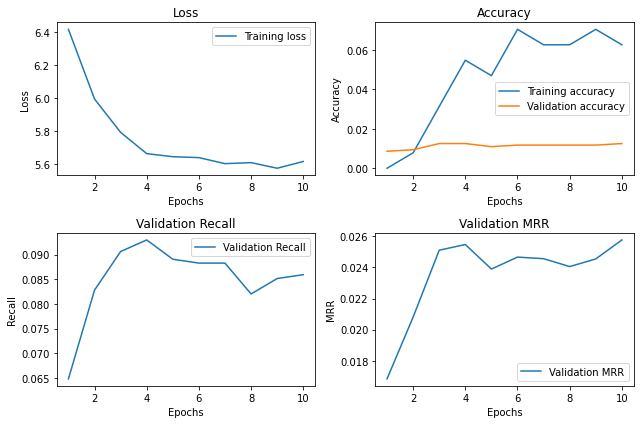

Evaluation:  23%|██▎       | 9/39 [00:04<00:13,  2.20it/s]


- Recall@20: 0.134549
- MRR@20: 0.042920


🕊 hsz(50), drop_rate(0.001), learning_rate(0.001), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_33 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_33 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


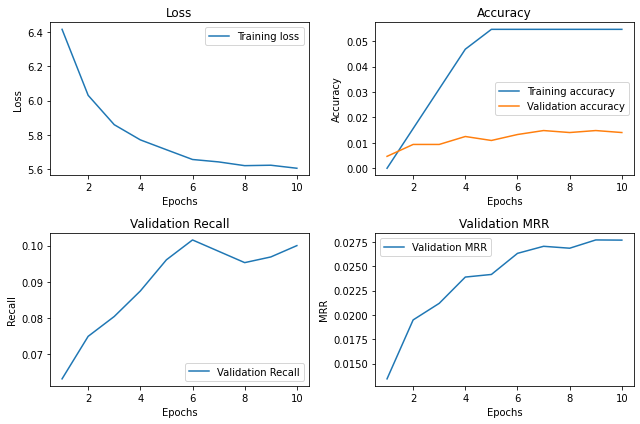

Evaluation:  23%|██▎       | 9/39 [00:04<00:13,  2.14it/s]

- Recall@20: 0.138021
- MRR@20: 0.046486




In [208]:
res_drop = grid_search(args_drop)

,hidden size,drop rate,learning rate,epochs,Recall@20,MRR@20
0,50,0.100,0.001,10,0.148438,0.046016
1,50,0.010,0.001,10,0.134549,0.042920
2,50,0.001,0.001,10,0.138021,0.046486


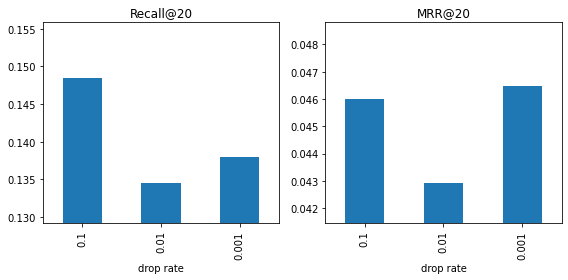

In [209]:
show_grid_search_result(res_drop, 'drop rate', ['Recall@20', 'MRR@20'])

In [ ]:
- drop rate를 0.1, 0.01, 0.001로 변화시켰을 때, Recall@20은 0.1 > 0.001 > 0.01 순으로 높아졌다.

### 4. 하이퍼 파라미터 튜닝 - epochs

In [219]:
args_epochs = [Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20),
             Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20),
             Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20),
             Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)]

🕊 hsz(50), drop_rate(0.1), learning_rate(0.001), epochs(5)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_34 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_34 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


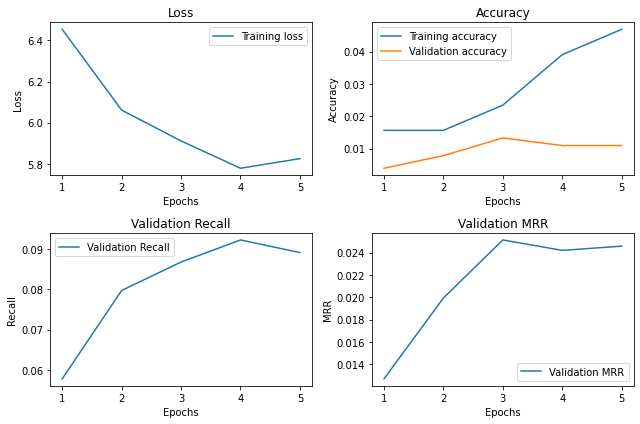

Evaluation:  23%|██▎       | 9/39 [00:04<00:14,  2.06it/s]


- Recall@20: 0.133681
- MRR@20: 0.043912


🕊 hsz(50), drop_rate(0.1), learning_rate(0.001), epochs(10)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_35 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_35 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


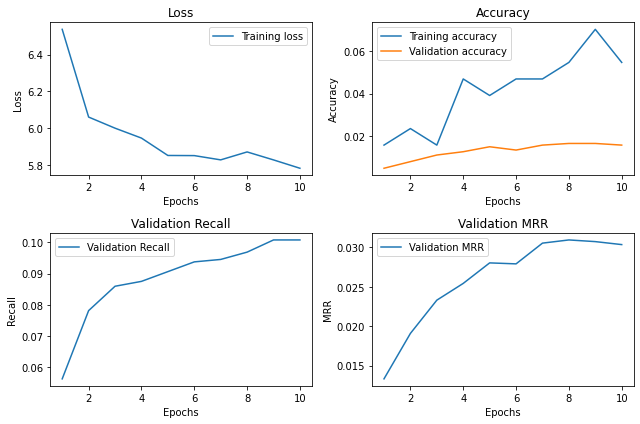

Evaluation:  23%|██▎       | 9/39 [00:04<00:14,  2.13it/s]


- Recall@20: 0.141493
- MRR@20: 0.045161


🕊 hsz(50), drop_rate(0.1), learning_rate(0.001), epochs(15)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_36 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_36 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


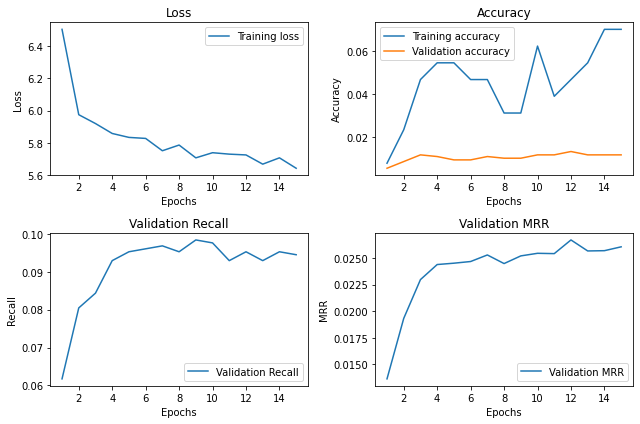

Evaluation:  23%|██▎       | 9/39 [00:03<00:12,  2.41it/s]


- Recall@20: 0.134549
- MRR@20: 0.042872


🕊 hsz(50), drop_rate(0.1), learning_rate(0.001), epochs(20)
Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_37 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_37 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


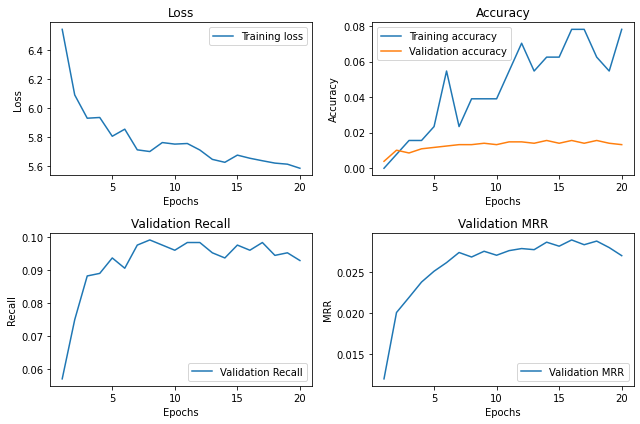

Evaluation:  23%|██▎       | 9/39 [00:03<00:13,  2.30it/s]

- Recall@20: 0.136285
- MRR@20: 0.043777




In [220]:
res_epochs = grid_search(args_epochs)

,hidden size,drop rate,learning rate,epochs,Recall@20,MRR@20
0,50,0.1,0.001,5,0.133681,0.043912
1,50,0.1,0.001,10,0.141493,0.045161
2,50,0.1,0.001,15,0.134549,0.042872
3,50,0.1,0.001,20,0.136285,0.043777


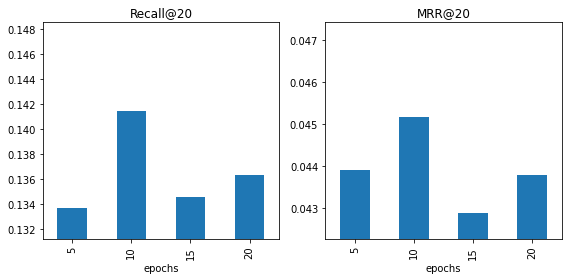

In [222]:
show_grid_search_result(res_epochs, 'epochs', ['Recall@20', 'MRR@20'])

- epochs를 증가시킬 수록 지표가 좋게 나올 것이라 예상했는데, 전혀 그렇지 않았고 10에서 가장 좋은 성능을 보였다.

### 5. 하이퍼 파라미터 튜닝 - summary

In [228]:
df_summary = pd.DataFrame(res + res_lr + res_drop + res_epochs)

In [229]:
df_summary.sort_values(['Recall@20', 'MRR@20'], ascending=False).reset_index(drop=True)

,hidden size,drop rate,learning rate,epochs,Recall@20,MRR@20
0,50,0.100,0.001,10,0.148438,0.046016
1,50,0.100,0.001,10,0.147569,0.048856
2,50,0.100,0.001,10,0.141493,0.045161
3,100,0.100,0.001,10,0.138889,0.045565
4,50,0.001,0.001,10,0.138021,0.046486
5,50,0.100,0.001,10,0.138021,0.043916
6,50,0.100,0.001,20,0.136285,0.043777
7,50,0.010,0.001,10,0.134549,0.042920
8,50,0.100,0.001,15,0.134549,0.042872
9,50,0.100,0.001,5,0.133681,0.043912


모든 실험 결과를 하나의 DataFrame로 정리하면 위와 같다.

## STEP 8. 영화 추천 받아 보기
---

### 1. 모델준비

위에서 선정한 하이퍼 하이퍼 파라미터를 적용하여 모델을 생성하고 학습시킨다.

In [269]:
args = Args(train, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)
_ = train_model_remove_tqdm(model, args)

Model: "SBR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_42 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_42 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


### 2. 데이터 준비

- 선호하는 영화 5개를 선정한 후, 이를 item_idx로 변화한다.
- 이 때, 배치의 크기를 맞추기 위하여 128-5만큼의 남은 공간을 임의의 데이터로 채워준다.

In [294]:
my_movie_id = [39 , 1721 , 1801, 3825, 2671]
my_movie_id = my_movie_id + [1]*(128-5)
my_movie_idx = [train[train['ItemId']==_id]['item_idx'].values[0] for _id in my_movie_id ]
my_movie_idx[:5]

[273, 2, 147, 2035, 1152]

- 입력 데이터에 one hot encoding을 진행하여 준다.

In [295]:
my_input = to_categorical(my_movie_idx, num_classes=train['ItemId'].nunique())
my_input = np.expand_dims(my_input, axis=1)
my_input.shape

(128, 1, 3307)

### 3. 예측 수행

In [299]:
pred = model.predict(my_input, batch_size=args.batch_size)
pred_arg = tf.argsort(pred, direction='DESCENDING')
pred_arg[:5].shape

TensorShape([5, 3307])

### 4. 예측 결과 확인

- 영화 정보 데이터 생성

In [348]:
movies = train.drop(['UserId', 'Rating', 'Time'], axis=1)
movies = movies.drop_duplicates().reset_index(drop=True)
movies

,ItemId,Title,Genres,item_idx
0,3186,"Girl, Interrupted (1999)",Drama,0
1,1270,Back to the Future (1985),Comedy|Sci-Fi,1
2,1721,Titanic (1997),Drama|Romance,2
3,1022,Cinderella (1950),Animation|Children's|Musical,3
4,2340,Meet Joe Black (1998),Romance,4
...,...,...,...,...
3302,3533,"Actor's Revenge, An (Yukinojo Henge) (1963)",Drama,3302
3303,1685,"I Love You, I Love You Not (1996)",Romance,3303
3304,3443,Born American (1986),Action|Drama|Thriller,3304
3305,874,Killer: A Journal of Murder (1995),Crime|Drama,3305


- 영화 정보 탐색 함수 정의

In [349]:
def get_movie_info(item_idx):
    return movies[movies['item_idx']==item_idx]

#### A. 첫번째 추천 영화 

- 입력 영화

In [350]:
get_movie_info(my_movie_idx[0])

,ItemId,Title,Genres,item_idx
273,39,Clueless (1995),Comedy|Romance,273


첫 번째로 테스트했던 영화는 코미디/로맨스 장르의 클루리스였다.

- 추천 영화 상위 10개 확인

In [351]:
recommended_1 = get_movie_info(pred_arg[0][0].numpy())
for idx in pred_arg[0][1:10].numpy():
    recommended_1 = recommended_1.append(get_movie_info(idx))
recommended_1

,ItemId,Title,Genres,item_idx
47,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,47
214,2716,Ghostbusters (1984),Comedy|Horror,214
474,223,Clerks (1994),Comedy,474
293,1517,Austin Powers: International Man of Mystery (1...,Comedy,293
45,588,Aladdin (1992),Animation|Children's|Comedy|Musical,45
120,1265,Groundhog Day (1993),Comedy|Romance,120
280,1923,There's Something About Mary (1998),Comedy,280
227,2700,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy,227
118,356,Forrest Gump (1994),Comedy|Romance|War,118
731,3176,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,731


클루리스는 대표적인 하이틴 로맨스 장르영화로 이를 선호한다면, 추천 타겟 인물은 젊은 혹은 어린 연령대의 무겁지 않은 분위기의 영화를 좋아할 것이라는 추측이 가능하다. 추천 결과에도 동일한 특징을 보이는 영화들이 잘 추천되었다고 볼 수 있다.  고스트버스터즈, 점원들, 오스틴 파워, 사우스 파크는 가볍게 보기 좋은 코미디물이고 메리에겐 뭔가 특별한 것이 있다 역시 가볍게 보기 좋은 하이틴 로맨스이다. 클루리스를 재밋게 보았다면 흥미를 가질 법한 영화들로 추천 목록이 구성된 것을 확인 할 수 있었다.

#### B. 두번째 추천 영화

- 입력 영화

In [342]:
get_movie_info(my_movie_idx[1])

,ItemId,Title,Genres,item_idx
2,1721,Titanic (1997),Drama|Romance,2


두번째로 테스트했던 영화는 로맨스/드라마 장르의 타이타닉이었다.

- 추천 영화 상위 10개 확인

In [374]:
recommended_2 = get_movie_info(pred_arg[1][0].numpy())
for idx in pred_arg[1][1:10].numpy():
    recommended_2 = recommended_2.append(get_movie_info(idx))
recommended_2

,ItemId,Title,Genres,item_idx
47,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,47
214,2716,Ghostbusters (1984),Comedy|Horror,214
474,223,Clerks (1994),Comedy,474
280,1923,There's Something About Mary (1998),Comedy,280
731,3176,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,731
293,1517,Austin Powers: International Man of Mystery (1...,Comedy,293
28,2762,"Sixth Sense, The (1999)",Thriller,28
227,2700,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy,227
45,588,Aladdin (1992),Animation|Children's|Comedy|Musical,45
87,1784,As Good As It Gets (1997),Comedy|Drama,87


이번 추천 결과에서 단 2개의 영화를 제외하면 이전 추천 목록(클루리스)와 동일한 것을 볼 수 있다. 비극적 로맨스를 다룬 타이타닉을 기반으로 결과치고는 타이타닉과의 공통점을 잘 찾을 수 없었다. 꼽아보자면 1990년대 후반에 개봉한 좋은 평점을 받은 영화 정도를 찾을 수 있을 것이다.

#### C. 세번쨰 추천 영화

- 입력 영화

In [354]:
get_movie_info(my_movie_idx[2])

,ItemId,Title,Genres,item_idx
147,1801,"Man in the Iron Mask, The (1998)",Action|Drama|Romance,147


세번째로 테스트했던 영화는 액션/드라마/로맨스 장르의 아이언 마스크였다.

- 추천 영화 상위 10개 확인

In [355]:
recommended_3 = get_movie_info(pred_arg[2][0].numpy())
for idx in pred_arg[2][1:10].numpy():
    recommended_3 = recommended_3.append(get_movie_info(idx))
recommended_3

,ItemId,Title,Genres,item_idx
293,1517,Austin Powers: International Man of Mystery (1...,Comedy,293
350,364,"Lion King, The (1994)",Animation|Children's|Musical,350
108,3255,"League of Their Own, A (1992)",Comedy|Drama,108
47,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,47
670,357,Four Weddings and a Funeral (1994),Comedy|Romance,670
486,2302,My Cousin Vinny (1992),Comedy,486
273,39,Clueless (1995),Comedy|Romance,273
475,3253,Wayne's World (1992),Comedy,475
45,588,Aladdin (1992),Animation|Children's|Comedy|Musical,45
87,1784,As Good As It Gets (1997),Comedy|Drama,87


삼총사의 후일담을 영화한 아이언 마스크는 액션 영화임에도 코미디 영화가 다수 추천되었다. 이것을 보고 추천이 잘 된 편이라고 생각하였는데 그 이유는 아이언 마스크 영화 역시 코믹한 상황들이 다수 연출되어 중세를 배경으로 하지만 가볍게 몰입하여 보기 좋은 영화이기 때문이다.

#### D. 네번째 추천 영화

- 입력 영화

In [356]:
get_movie_info(my_movie_idx[3])

,ItemId,Title,Genres,item_idx
2035,3825,Coyote Ugly (2000),Drama,2035


네번째로 테스트했던 영화는 드라마 장르의 코요테 어글리였다.

- 추천 영화 상위 10개 확인

In [362]:
recommended_4 = get_movie_info(pred_arg[3][0].numpy())
for idx in pred_arg[3][1:10].numpy():
    recommended_4 = recommended_4.append(get_movie_info(idx))
recommended_4

,ItemId,Title,Genres,item_idx
36,1029,Dumbo (1941),Animation|Children's|Musical,36
350,364,"Lion King, The (1994)",Animation|Children's|Musical,350
392,1393,Jerry Maguire (1996),Drama|Romance,392
470,3160,Magnolia (1999),Drama,470
458,3751,Chicken Run (2000),Animation|Children's|Comedy,458
400,3148,"Cider House Rules, The (1999)",Drama,400
3,1022,Cinderella (1950),Animation|Children's|Musical,3
91,3578,Gladiator (2000),Action|Drama,91
45,588,Aladdin (1992),Animation|Children's|Comedy|Musical,45
120,1265,Groundhog Day (1993),Comedy|Romance,120


🔥 추천 결과들 중 가장 놀라웠다. 장르만 보면 드라마 장르의 영화에 왜 이렇게 애니메이션이 많이 추천되었는가에 대한 의문을 가질 수 있지만 해당 애니메이션들의 특징은 ost로 유명한 디즈니사의 영화라는 것이다. 그리고 코요테 어글리는 싱어송라이터의 꿈을 가지고 상경한 주인공이 한 클럽에 취직을 하면서 겪에 되는 꿈과 사랑 그리고 현실에 대한 영화로 ost인 *Can not Fight the Moonlight*도 대중의 많은 사랑을 받았다. "ost가 좋은 영화"를 테마로 생각하면 꽤 잘 추천되었다고 볼 수 있다.<br>
추천 목록에서 3위를 기록한 제리 맥과이어도 일과 사랑에 대한 드라마를 담고 있다는 것에서 코요테 어글리를 재밋게 본 사람이라면 충분이 흥미를 가질 수 있을 것이다.

#### E. 다섯번째 추천 영화

- 입력 영화

In [359]:
get_movie_info(my_movie_idx[4])

,ItemId,Title,Genres,item_idx
1152,2671,Notting Hill (1999),Comedy|Romance,1152


마지막으로 테스트했던 영화는 코미디/로맨드 장르의 노팅힐이었다.

- 추천 영화 상위 10개 확인

In [363]:
recommended_5 = get_movie_info(pred_arg[4][0].numpy())
for idx in pred_arg[4][1:10].numpy():
    recommended_5 = recommended_5.append(get_movie_info(idx))
recommended_5

,ItemId,Title,Genres,item_idx
173,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,173
377,1573,Face/Off (1997),Action|Sci-Fi|Thriller,377
337,2406,Romancing the Stone (1984),Action|Adventure|Comedy|Romance,337
152,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,152
312,377,Speed (1994),Action|Romance|Thriller,312
144,780,Independence Day (ID4) (1996),Action|Sci-Fi|War,144
129,380,True Lies (1994),Action|Adventure|Comedy|Romance,129
575,2011,Back to the Future Part II (1989),Comedy|Sci-Fi,575
677,3175,Galaxy Quest (1999),Adventure|Comedy|Sci-Fi,677
682,2407,Cocoon (1985),Comedy|Sci-Fi,682


난해한 추천 결과이다. 노팅힐에서 서점을 운영하는 소심한 남자와 세계적인 여배우의 로맨스라는 주제가 SF적이기는 하지만 큰 연관성을 잘 모르겠다. 노팅힐과 맨인블랙, 노팅힐과 스타워즈, 노팅힐과 백투더퓨쳐스 모두 썩 어울리는지 않는 조합인 것 같다.

## STEP 9. 결론
---

### 프로젝트 평가
1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다. 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.
    - 데이터셋을 나름의 규칙을 가지고 분석하여 전처리를 진행하였다.
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
    - epoch가 증가함에 따라 train loss가 안정적으로 감소하였고 validation reacll과 mrr은 증가하는 추세를 보였다. 다만 하이퍼 파라미터에 따라 안정적이지 못한 경향을 보이는 경우가 있었기는 하였다.
3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다. 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.
    - 하이퍼 파라미터인 hidden size, learning rate, epochs를 변화시켜 가며 지표의 변화를 관찰하여 보았다.

### 회고
- 이전 프로젝트에서 동일한 데이터셋을 이용하여 ALS를 사용한 MF 모델로 추천 시스템을 만들어본 적이 있다. 체감으로는 이번 프로젝트인 SBR 방식이 더 추천이 잘 된다고 생각되었다. 예를 들어 동일하게 클루리스를 보았다고 입력을 넣었을 때, 추천 받은 목록을 비교하면 다음과 같다.
    - MF : 에이스 가이, 댄스 위드 미, 네 번의 결혼식과 한 번의 장례식, 카잠, 베이비시터
    - SBR : 벅스 라이프, 고스트버스터즈, 점원들, 오스틴 파워, 알라딘
- SBR이 더 잘 추천 되었다고 생각한 근거는 적어도 아는 영화가 추천되었다는 점이었다. 코미디의 측면에서 보자면 MF 쪽이 훨씬 잘 추천되었기 때문에 어쩌면 보는 사람에 따라 MF가 더 좋은 성능을 보인다고 평가할 수도 있을 것 같다.
- 어쩌면 프로젝트에 사용된 데이터가 추천을 위해 사용되기에는 너무 적은 것이 아닌가하는 생각이 들기도 하였다. 시간이 되면 `Movielens 25M Dataset`을 이용하여 모델을 학습시켜 보는 것도 나쁘지 않을 것 같다.

## ref
---
- [precision at K, MAP, recall at K](https://ddiri01.tistory.com/321)
- [추천시스템에 사용되는 metrics 정리](https://zzaebok.github.io/recommender_system/metrics/rec_metrics/)